/tmp/ipykernel_7852/3416626595.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/home/federico/miniconda3/envs/snl/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


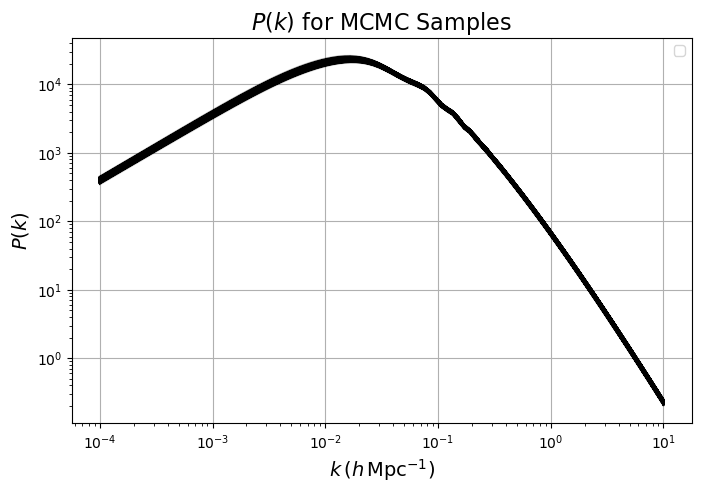

In [15]:
import numpy as np
from getdist import loadMCSamples
from colossus.cosmology import cosmology
#from colossus.lss import power
import matplotlib.pyplot as plt

# Load MCMC samples using GetDist
chain_root = '../data/CosmoParams/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE'
samples = loadMCSamples(chain_root)

# Extract relevant parameters for each sample
omega_m = samples.samples[:, samples.index['omegam']]
sigma_8 = samples.samples[:, samples.index['sigma8']]
H_0 = samples.samples[:, samples.index['H0']] # if 'H0' in samples.paramNames.names else 67.2  # Planck value
omega_bh2 = samples.samples[:, samples.index['omegabh2']]
omega_b = omega_bh2/(H0/100)**2
n_s = samples.samples[:, samples.index['ns']]  # Scalar spectral index

# Define k values for the power spectrum
k_values = np.logspace(-4, 1, 100)  # k range from 10^-4 to 10^1 h/Mpc

# Prepare to store P(k) for each sample
P_k = []

# Loop over each sample to calculate P(k)
for i in range(len(omega_m)):
    cosmo_params = {
        'Om0': omega_m[i],
        'sigma8': sigma_8[i],
        'H0': H_0[i], #h[i] if isinstance(h, np.ndarray) else h*100,
        'Ob0': omega_b[i],
        'ns': n_s[i]
    }

    # Set the cosmology for this set of parameters
    cosmo = cosmology.setCosmology('myCosmo', params = cosmology.cosmologies['planck18'], **cosmo_params)

    #cosmology.setCurrent(cosmo_params)

    # Calculate P(k) using COLOSSUS
    P = cosmo.matterPowerSpectrum(k_values,z=0.0)
    P_k.append(P)

# Convert to a NumPy array for easier manipulation
P_k = np.array(P_k)

# Example plot for the first sample
plt.figure(figsize=(8, 5))
for i in range(len(omega_m)):
    plt.loglog(k_values, P_k[i],c='k',alpha=.05)#, label='Sample 1')
plt.title(r'$P(k)$ for MCMC Samples', fontsize=16)
plt.xlabel(r'$k \, (h \, \text{Mpc}^{-1})$', fontsize=14)
plt.ylabel(r'$P(k)$', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [12]:
H0

array([67.34131, 67.44385, 67.83936, ..., 67.17529, 67.2876 , 66.56982])

/tmp/ipykernel_7852/764061445.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


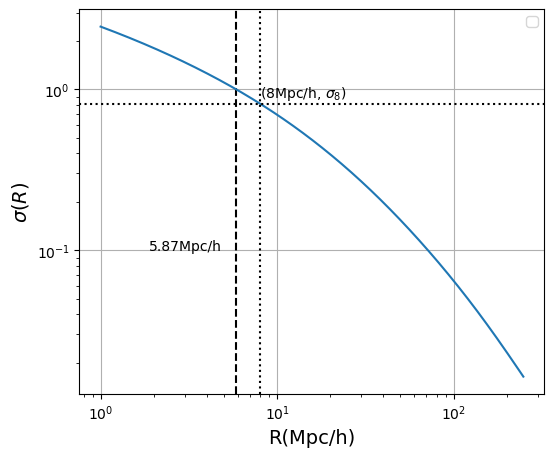

In [17]:
R = 10**np.arange(0,2.4,0.005)
sigma_tophat = cosmo.sigma(R, z=0.0)

def get_Rnl(R,sigma,sigma_nl=1):
    from scipy.interpolate import CubicSpline
    spl = CubicSpline(R,sigma-sigma_nl)
    return spl.roots(sigma_nl)[0]

plt.figure(figsize=(6, 5))
plt.loglog()

# R para sigma=1
R_nl = get_Rnl(R,sigma_tophat,1)
plt.axvline(R_nl,ls='--',c='k')
plt.text(R_nl-4,1e-1,f'{R_nl:.2f}Mpc/h')

# Sigma vs R
plt.plot(R, sigma_tophat, '-')

# Chequear que sigma(R=8) == sigma8 de la cadena MCMC
plt.axhline(sigma_8[-1],ls=':',c='k')
plt.axvline(8,ls=':',c='k')
plt.text(8.05,sigma_8[-1]+.08,r'(8Mpc/h, $\sigma_8$)')

plt.xlabel('R(Mpc/h)', fontsize=14)
plt.ylabel(r'$\sigma(R)$', fontsize=14)
plt.grid(True)
plt.legend()

In [19]:
def get_Rnl(R,sigma,sigma_nl=1):
    from scipy.interpolate import CubicSpline
    spl = CubicSpline(R,sigma-sigma_nl)
    return spl.roots(sigma_nl)[0]

def get_Snl(samples, zs):

    import numpy as np
    from colossus.cosmology import cosmology

    # Extract relevant parameters for each sample
    omega_m = samples.samples[:, samples.index['omegam']]
    sigma_8 = samples.samples[:, samples.index['sigma8']]
    H0 = samples.samples[:, samples.index['H0']] # if 'H0' in samples.paramNames.names else 67.2  # Planck value
    omega_bh2 = samples.samples[:, samples.index['omegabh2']]
    omega_b = omega_bh2/(H0/100)**2
    n_s = samples.samples[:, samples.index['ns']]  # Scalar spectral index

    # R to calculate Sigma(R)
    R = 10**np.arange(0,2.4,0.005)

    # Set array for storing S_nl
    S_nl = np.zeros((len(zs),len(omega_m)))

    for j in range(len(zs)):
        for i in range(len(omega_m)):
            cosmo_params = {
                'Om0': omega_m[i],
                'sigma8': sigma_8[i],
                'H0': H0[i], #if isinstance(H0, np.ndarray) else h*100,
                'Ob0': omega_b[i],
                'ns': n_s[i]
            }

            # Set the cosmology for this set of parameters
            cosmo = cosmology.setCosmology('myCosmo', params = cosmology.cosmologies['planck18'], **cosmo_params)

            # Get R_nl
            sigma_tophat = cosmo.sigma(R, z=zs[j])
            R_nl = get_Rnl(R,sigma_tophat,1)

            # Get Dv
            D_H = cosmo.comovingDistance(z_min=0,z_max=zs[j]) #Comoving distance
            D_M = (1+zs[j])*cosmo.angularDiameterDistance(zs[j]) #Angular diameter distance
            #D_M = cosmo.angularDiameterDistance(zs[j]) #Angular diameter distance
            D_V = (D_H*D_M**2)**(1./3)

            # Get S_NL
            S_nl[j,i] = R_nl/D_V

    return S_nl

from getdist import loadMCSamples
import matplotlib.pyplot as plt

chain_root_cmb = '../data/CosmoParams/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE'
chain_root_cl = '../data/CosmoParams/base/DES_DESpriors/base_DES_DESpriors'

zs = [0.1]

# Load MCMC samples using GetDist
samples_cmb = loadMCSamples(chain_root_cmb)
#samples_cl = loadMCSamples(chain_root_cl)

s_nl_cmb = get_Snl(samples_cmb,zs)
#s_nl_cl = get_Snl(samples_cl,zs)

# Plotting Omega_m vs s_nl
# ------------------------------
omegam_cmb = samples_cmb.samples[:, samples_cmb.index['omegam']]
#omegam_cl = samples_cl.samples[:, samples_cl.index['omegam']]

plt.figure(figsize=(8, 6))
for i in range(len(s_nl_cmb)):
    plt.scatter(omegam_cmb*h**2, s_nl_cmb[i], alpha=0.3, color='C00', s=10)
    #plt.scatter(omegam_cl*h**2, s_nl_cl[i], alpha=0.3, color='C01', s=10)
plt.xlabel(r'$\Omega_m h^2$', fontsize=14)
plt.ylabel(r'$s_{NL}$', fontsize=14)
plt.title(r'$\Omega_m h^2$ vs $S_{NL}$ from PLA MCMC Samples', fontsize=16)
plt.grid(True)
plt.show()